In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# TEDtalks: `pandas` filters and visualizations

In [5]:
import pandas
import re
colnames = ['author', 'title', 'date' , 'length', 'text']
df = pandas.read_csv('./data/talks-v1b.csv', names=colnames)

df['date'] = df['date'].replace(to_replace='[A-Za-z ]', value='', regex=True)

data2006 = df[df['date'] == '2006']

talks = data2006.text.tolist()
authors = data2006.author.tolist()
dates = data2006.date.tolist()

# Combining year with presenter for citations
citations = [author+" "+date for author, date in zip(authors, dates)]

In [12]:
import numpy as np
import sklearn.feature_extraction.text as text
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Function for printing topic words (used later):
def print_top_words(model, feature_names, n_top_words):
    for topic_id, topic in enumerate(model.components_):
        print('\nTopic {}:'.format(int(topic_id))) 
        print(''.join([feature_names[i] + ' ' + str(round(topic[i], 2))
              +', ' for i in topic.argsort()[:-n_top_words - 1:-1]]))
    
n_samples = len(talks)
n_features = 1000
n_topics = 15
n_top_words = 15

# Use tf-idf features for NMF.
tfidf_vectorizer = text.TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(talks)
tf_vectorizer = text.CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')

# Use tf (raw term count) features for LDA.
tf = tf_vectorizer.fit_transform(talks)

In [13]:
# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_topics={}, n_samples={} and n_features={}...".format(n_topics, n_samples, n_features))
nmf = NMF(n_components=n_topics, 
          random_state=1,
          alpha=.1, 
          l1_ratio=.5).fit(tfidf)

Fitting the NMF model with tf-idf features, n_topics=15, n_samples=50 and n_features=1000...


In [14]:
print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words) #n_top_words can be changed on the fly


Topics in NMF model:

Topic 0:
people 0.33, know 0.23, world 0.2, ve 0.17, said 0.16, things 0.16, say 0.15, years 0.15, want 0.14, time 0.13, got 0.12, actually 0.12, ll 0.1, lot 0.1, work 0.09, 

Topic 1:
countries 0.26, data 0.26, africa 0.2, world 0.2, families 0.12, country 0.12, income 0.11, aid 0.1, asia 0.1, health 0.1, uganda 0.09, students 0.08, south 0.07, america 0.07, economy 0.07, 

Topic 2:
interface 0.31, multi 0.22, kind 0.19, touch 0.17, hands 0.17, data 0.1, things 0.09, use 0.08, nasa 0.07, lab 0.07, tool 0.06, research 0.05, control 0.04, expect 0.04, points 0.04, 

Topic 3:
technology 0.53, evolution 0.22, life 0.16, game 0.15, actually 0.12, machines 0.09, biological 0.08, technologies 0.08, species 0.07, things 0.06, general 0.05, wants 0.04, took 0.04, price 0.03, term 0.03, 

Topic 4:
cancer 0.53, muscle 0.45, cells 0.26, tumor 0.16, body 0.11, blood 0.07, cell 0.04, articles 0.04, brain 0.02, reading 0.02, disease 0.01, growth 0.01, medical 0.01, tried 0.01,

In [15]:
# Now to associate NMF topics to documents...
dtm = tf.toarray()
doctopic = nmf.fit_transform(dtm)
print("Top NMF topics in...")
for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    print("{}: {}".format(citations[i], top_topics_str))

Top NMF topics in...
Al Gore 2006: 2 0 12
David Pogue 2006: 10 12 2
Cameron Sinclair 2006: 12 14 6
Jehane Noujaim 2006: 0 6 14
Larry Brilliant 2006: 9 2 14
Nicholas Negroponte 2006: 12 13 10
Jeff Han 2006: 13 10 1
Sirena Huang 2006: 1 11 2
Jennifer Lin 2006: 12 11 10
Amy Smith 2006: 13 12 11
Ross Lovegrove 2006: 13 12 10
Richard Baraniuk 2006: 12 0 6
Majora Carter 2006: 12 3 14
Jimmy Wales 2006: 12 0 11
Mena Trott 2006: 0 2 13
Ze Frank 2006: 0 11 2
Helen Fisher 2006: 4 14 13
Eve Ensler 2006: 14 1 11
David Deutsch 2006: 10 1 12
Richard Dawkins 2006: 6 1 4
Malcolm Gladwell 2006: 2 9 13
Steven Levitt 2006: 3 14 13
Barry Schwartz 2006: 11 10 13
Ken Robinson 2006: 2 13 0
Dan Gilbert 2006: 10 8 11
Eva Vertes 2006: 5 14 13
Aubrey de Grey 2006: 11 14 13
Iqbal Quadir 2006: 9 13 0
Jacqueline Novogratz 2006: 14 13 9
Ashraf Ghani 2006: 6 9 12
Sasa Vucinic 2006: 13 11 9
Burt Rutan 2006: 10 12 11
Ben Saunders 2006: 10 14 2
Edward Burtynsky 2006: 13 2 14
Hans Rosling 2006: 6 3 2
Robert Fischell 2006:

In [16]:
doctopic.shape

(50, 15)

In [17]:
doctopic

array([[  5.47009445e-01,   6.42458320e-03,   6.74609594e-01,
          2.31820838e-01,   1.93108142e-01,   0.00000000e+00,
          4.15429304e-01,   1.04336530e-01,   0.00000000e+00,
          0.00000000e+00,   3.35002416e-01,   2.30887922e-01,
          4.88786866e-01,   1.25905629e-01,   1.80600026e-01],
       [  5.61154575e-01,   3.80024770e-01,   1.04059368e+00,
          0.00000000e+00,   1.72781091e-02,   0.00000000e+00,
          0.00000000e+00,   2.61249126e-01,   3.68440932e-01,
          0.00000000e+00,   2.40577850e+00,   7.23595678e-02,
          1.82774411e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.50612669e-01,   0.00000000e+00,   7.14248427e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          9.59162817e-01,   0.00000000e+00,   0.00000000e+00,
          1.21698675e-01,   0.00000000e+00,   0.00000000e+00,
          4.67371896e+00,   2.89336900e-01,   1.08063396e+00],
       [  5.49287115e+00,   0.00000000e+00,   0.00000000e+00,
     

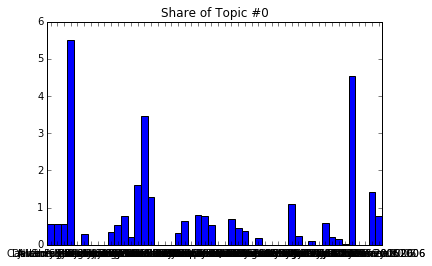

In [28]:
# Bar Chart of One Topic
import matplotlib.pyplot as plt

N, K = doctopic.shape
ind = np.arange(N)
width = 1
plt.bar(ind, doctopic[:,0], width=width)
plt.xticks(ind + width/2, citations) # put labels in the center
plt.title('Share of Topic #0')

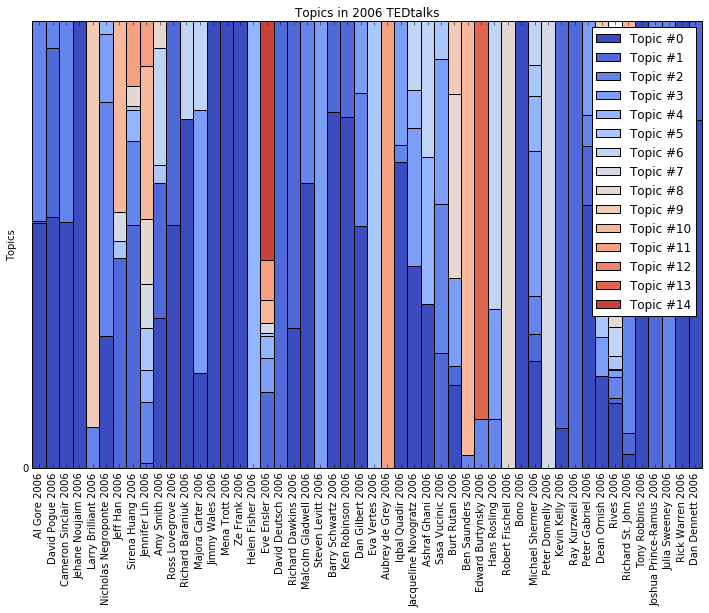

In [33]:
# Stacked Bar Chart of All Topics
# Thanks to Alan Riddell (https://de.dariah.eu/tatom/topic_model_visualization.html)

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(18.5, 10.5)

N, K = doctopic.shape  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the texts
width = 1  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, doctopic[:, k], width, color=color)
    else:
        p = plt.bar(ind, doctopic[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += doctopic[:, k]
    plots.append(p)

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')
plt.title('Topics in 2006 TEDtalks')
plt.xticks(ind+width/2, citations, rotation='vertical')
plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Working with LSI/LSA to get Elbow graph for k-means

I got the idea from [Sujit Pal][].

[Sujit Pal]: http://sujitpal.blogspot.com/2014/08/topic-modeling-with-gensim-over-past.html

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

lsa = TruncatedSVD()
my_lsa = lsa.fit_transform(tfidf)
#normed = Normalizer(copy=False).fit_transform(my_lsa)
#cosine_similarity(normed)

In [ ]:
print(normed)

In [ ]:
# write out coordinates to file
fcoords = open(os.path.join(MODELS_DIR, "coords.csv"), 'wb')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()